In [1]:
!pip install --upgrade gensim

     |████████████████████████████████| 24.1 MB 1.5 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [2]:
import os
import tensorflow as tf
import keras
import keras.applications.vgg16
from keras.utils import np_utils
import numpy as np
import matplotlib.pyplot as plt
import string
from pickle import load, dump
from nltk.translate.bleu_score import corpus_bleu
import gensim

from google.colab import drive
drive.mount('/content/drive')

tf.test.gpu_device_name()

Mounted at /content/drive


'/device:GPU:0'

In [3]:
def feature_extractions(directory):
    """
    Input: directory of images
    Return: A dictionary of features extracted by VGG-16, size 4096.
    """
    
    model = keras.applications.vgg16.VGG16()
    model = keras.models.Model(inputs=model.input, outputs=model.layers[-2].output) #Remove the final layer
    
    features = {}
    for f in os.listdir(directory):
        filename = directory + "/" + f
        identifier = f.split('.')[0]
        
        image = keras.preprocessing.image.load_img(filename, target_size=(224,224))
        arr = keras.preprocessing.image.img_to_array(image, dtype=np.float32)
        arr = arr.reshape((1, arr.shape[0], arr.shape[1], arr.shape[2]))
        arr = keras.applications.vgg16.preprocess_input(arr)
    
        feature = model.predict(arr, verbose=0)
        features[identifier] = feature
        
        print("feature extraction: {}".format(f))
    return(features)

features = feature_extractions("/content/drive/My Drive/Flickr8k_Dataset")

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
feature extraction: 3138433655_ea1d59e5b7.jpg
feature extraction: 3133403457_95dfe11da1.jpg
feature extraction: 3116039960_54d1d68145.jpg
feature extraction: 3154886184_ac842655b6.jpg
feature extraction: 3148193539_de9dd48fc8.jpg
feature extraction: 3162289423_4ca8915d0c.jpg
feature extraction: 3112635165_2d614d7c1a.jpg
feature extraction: 3151365121_e2a685a666.jpg
feature extraction: 3171651115_e07b9d08f6.jpg
feature extraction: 3155400369_69e3d6d70f.jpg
feature extraction: 3118534315_cc03e5ddab.jpg
feature extraction: 3138504165_c7ae396294.jpg
feature extraction: 3109136206_f7d201b368.jpg
feature extraction: 3131990048_369b081021.jpg
feature extraction: 3150252702_828a570d46.jpg
feature extraction: 3169394115_2193158cee.jpg
feature extraction: 311146855_0b65fdb169.jpg
feature extraction: 3125628091_25a31709df.jpg
feature extraction: 3123463486_f5b36a3624.jpg
feature extraction: 3125309108_1011486589.jpg
fea

In [4]:
def caption_dictionary(raw_caption):
    """
    Input: raw_caption as retrieved from the dataset
    Return: A dictionary mapping [photo_id] -> caption_list of that photo
    """
    captions = {}
    for line in raw_caption.split('\n'):
        if len(line) < 1:
            continue
        
        tmp = line.split()
        photo_id = tmp[0].split('.')[0] #id
        caption = ' '.join(tmp[1:])
        
        if photo_id not in captions.keys():
            captions[photo_id] = []
        captions[photo_id].append(caption) #A list of captions

    return(captions)

def cleaning(caption_dict):
    """
    Input: A dictionary of caption_list returned by caption_dictionary()
    Output: The cleaned caption dictionary
    """
    trans_table = str.maketrans('', '', string.punctuation)
    for photo_id, caption_list in caption_dict.items():
        for i in range(len(caption_list)):
            caption = caption_list[i]
            tmp = caption.split()
            
            tmp = [t.lower() for t in tmp] #Lower case
            tmp = [t.translate(trans_table) for t in tmp] #Remove punctuation
            tmp = [t for t in tmp if len(t) > 1] #Remove words with a single alphabet
            tmp = [t for t in tmp if t.isalpha()] #Remove words which contain non-alphabet
            
            caption_list[i] = ' '.join(tmp)

    return(None)


with open("/content/drive/My Drive/Flickr8k_text/Flickr8k.token.txt", "r") as f:
    raw_caption = f.read()
        
caption_dict = caption_dictionary(raw_caption)
cleaning(caption_dict)

In [5]:
def caption_to_list(caption_dict):
    #Return: a list of all captions from the caption_dict
    captions = []
    for caption_list in caption_dict.values():
        for c in caption_list:
            captions.append(c.split())
    return(captions)
    
def create_tokenizer(caption_dict, num_vocab=None):
    """
    Input: caption dictionary, num_vocab
    Output: Tokenizer fitted on the captions in the dictionary, with maximum number of vocab = num_vocab
    """
    tokenizer = keras.preprocessing.text.Tokenizer(num_words=num_vocab)
    captions = caption_to_list(caption_dict)
            
    tokenizer.fit_on_texts(captions)
    return(tokenizer)

def word2idx(word):
    """
    Input: word to encode
    Output: index of the word
    """
    return word_model.wv.key_to_index[word]

def idx2word(idx):
    """
    Input: index of the word to decode
    Output: word to decode
    """
    return word_model.wv.index_to_key[idx]

#Identify training / development / testing set
def dataset(filename):
    """
    Input: filename of dataset
    Output: A list of identifier in the dataset
    """
    dataset = []
    with open(filename, "r") as f:
        text = f.read()
    
    for line in text.split('\n'):
        if len(line) < 1:
            continue
        dataset.append(line.split('.')[0])
        
    return(dataset)

def load_features(dataset, features):
    """
    Input: dataset (list of identifier)
    Output: The VGG-16 features according to the identifiers
    """
    features = {photo_id: features[photo_id] for photo_id in dataset}
    
    return(features)
    
def load_captions(dataset, caption_dict, wrapping = 0):
    """
    Input: dataset (list of identifier), wrapping (by startseq / endseq)
    Output: The caption_dict according to the identifiers, with / without wrapping of (startseq, endseq)
    """
    caption_dict = {photo_id: caption_dict[photo_id] for photo_id in dataset}
    
    if wrapping:
        for photo_id, caption_list in caption_dict.items():
            for i in range(len(caption_list)):
                tmp = caption_list[i].split()
                caption_list[i] = 'startseq '+ ' '.join(tmp) + ' endseq'
    
    return(caption_dict)



train = dataset("/content/drive/My Drive/Flickr8k_text/Flickr_8k.trainImages.txt")
dev = dataset("/content/drive/My Drive/Flickr8k_text/Flickr_8k.devImages.txt")
test = dataset("/content/drive/My Drive/Flickr8k_text/Flickr_8k.testImages.txt")
    
train_caption_dict = load_captions(train,caption_dict, 1)
train_features = load_features(train, features)
dev_caption_dict = load_captions(dev,caption_dict, 1)
dev_features = load_features(dev, features)
test_caption_dict = load_captions(test,caption_dict, 0)
test_features = load_features(test, features)

#Train word2vec
sentences = [['padd'] + sentence for sentence in caption_to_list(train_caption_dict)]
word_model = gensim.models.Word2Vec(sentences=sentences, vector_size=100, min_count=2, window=5, epochs=100, sg = 0)
pretrained_weights = word_model.wv.vectors
vocab_size, emdedding_size = pretrained_weights.shape
    
max_length = max([len(c) for c in caption_to_list(train_caption_dict)]) - 1 #Maximum length of input sequence
print("max length: {}".format(max_length))

max length: 33


In [6]:
def define_model(max_length, vocab_size, embedding_size, pretrained_weights):
    img_inputs = keras.layers.Input(shape=(4096,))
    img_dp1 = keras.layers.Dropout(rate=0.2)(img_inputs)
    img_dense = keras.layers.Dense(128)(img_dp1)
    img_bn1 = keras.layers.BatchNormalization()(img_dense)
    img_outputs = keras.layers.Activation(activation='relu')(img_bn1)
    #RepeatVector for matching timestep
    img_rep = keras.layers.RepeatVector(n=1)(img_outputs)
    
    text_inputs = keras.layers.Input(shape=(max_length,))
    text_embed = keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_size, weights = [pretrained_weights], mask_zero = True)(text_inputs)
    text_lstm = keras.layers.Bidirectional(keras.layers.LSTM(128), merge_mode = 'sum')(text_embed)

    #attention mechanism
    attention = keras.layers.Dense(1, activation='tanh')(text_lstm)
    attention = keras.layers.Flatten()(attention)
    attention = keras.layers.Activation('softmax')(attention)
    attention = keras.layers.RepeatVector(128)(attention)
    attention = keras.layers.Permute([2, 1])(attention)
    sent_representation = keras.layers.Multiply()([text_lstm, attention])
    
    decoder_inputs = keras.layers.Concatenate()([img_rep, sent_representation])
    decoder_dp1 = keras.layers.Dropout(rate=0.5, noise_shape=(None, 1, 256))(decoder_inputs)
    decoder_dense1 = keras.layers.Dense(256)(decoder_dp1)
    decoder_dp2 = keras.layers.Dropout(rate=0.5, noise_shape=(None, 1, 256))(decoder_dense1)
    decoder_relu1 = keras.layers.Activation(activation='relu')(decoder_dp2)
    decoder_outputs = keras.layers.Dense(vocab_size, activation='softmax')(decoder_relu1)
    
    model = keras.models.Model(inputs = [img_inputs, text_inputs], outputs=decoder_outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    print(model.summary())
    
    return(model)

"""
4. Progressive model training
"""

def generate_dataset(caption_dict, features, max_length, vocab_size, num_photos=32):
    """
    A generator of dataset for model training / validation.
    Input: train / val (caption_dict & features)
    Yield: a batch of [[X_img, X_text], Y] as the model input for model.fit_generator() / model.evaluate_generator()
    """
    
    #list of photo_ids
    photo_ids = list(caption_dict.keys())
    while 1:
        s = np.random.choice(np.arange(len(photo_ids)), size=len(photo_ids), replace=False)
        
        count = 0 #counter
        X_img = []
        X_text = []
        Y = []
        while 1:
            #sample the photo_id along the random sequence
            s1 = s[count]
            photo_id = photo_ids[s1]
            caption_list = caption_dict[photo_id]
            
            #sample the caption randomly
            s2 = np.random.choice(np.arange(len(caption_list)), size=1, replace=True)[0]
            caption = caption_list[s2].split()

            encoded = [word2idx(word) for word in caption if word in word_model.wv.key_to_index]
            
            for i in range(len(encoded)-1):
                tmp_text, tmp_Y = encoded[:i+1], encoded[i+1]
                padded_text = keras.preprocessing.sequence.pad_sequences([tmp_text], maxlen=max_length, padding='pre')[0]
                padded_Y = keras.utils.np_utils.to_categorical(tmp_Y, num_classes=vocab_size)
            
                X_img.append(features[photo_id][0])
                X_text.append(padded_text)
                Y.append([padded_Y])
            
            #Generate until: num_photos photos; iterate through all photos + restart
            count += 1
            if count % num_photos == 0:
                yield([[np.array(X_img), np.array(X_text)], np.array(Y)])
                
                X_img = []
                X_text = []
                Y = []
            if count >= len(photo_ids):
                if len(Y) > 0:
                    yield([[np.array(X_img), np.array(X_text)], np.array(Y)])
                break

#Training:
               
num_epoches = 9
num_photos = 32 #photos per batch
    
steps_per_epoch = int(len(train_caption_dict) / num_photos)
val_steps = int(len(dev_caption_dict) / num_photos)
    
model = define_model(max_length, vocab_size, emdedding_size, pretrained_weights)
    
train_generator = generate_dataset(train_caption_dict, train_features, max_length, vocab_size, num_photos)
dev_generator = generate_dataset(dev_caption_dict, dev_features, max_length, vocab_size, num_photos)

history = dict()
history['train_loss'] = []
history['train_acc'] = []
history['dev_loss'] = []
history['dev_acc'] = []
    
for i in range(num_epoches):
    hist = model.fit_generator(train_generator, steps_per_epoch = steps_per_epoch, epochs=5, verbose=1)
    
    history['train_loss'].append(hist.history['loss'][-1])
    history['train_acc'].append(hist.history['accuracy'][-1])
    dev_loss = model.evaluate_generator(dev_generator, steps = val_steps, verbose=1)
    history['dev_loss'].append(dev_loss[0])
    history['dev_acc'].append(dev_loss[1])
    print("The dev_loss at {i}-th epoch: {dev_loss}".format(i=i, dev_loss=np.round(dev_loss,2)))

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 33)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 33, 100)      447400      ['input_3[0][0]']                
                                                                                                  
 bidirectional (Bidirectional)  (None, 128)          234496      ['embedding[0][0]']              
                                                                                                  
 input_2 (InputLayer)           [(None, 4096)]       0           []                               
                                                                                            

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:109: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


187/187 [==============================] - 65s 289ms/step - loss: 5.4936 - accuracy: 0.1478
Epoch 2/5
187/187 [==============================] - 53s 286ms/step - loss: 4.6233 - accuracy: 0.2263
Epoch 3/5
187/187 [==============================] - 54s 287ms/step - loss: 4.3672 - accuracy: 0.2463
Epoch 4/5
187/187 [==============================] - 54s 287ms/step - loss: 4.2275 - accuracy: 0.2533
Epoch 5/5
187/187 [==============================] - 53s 285ms/step - loss: 4.1120 - accuracy: 0.2638


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:113: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.


31/31 [==============================] - 5s 59ms/step - loss: 3.8850 - accuracy: 0.2818
The dev_loss at 0-th epoch: [3.88 0.28]
Epoch 1/5
187/187 [==============================] - 54s 288ms/step - loss: 4.0282 - accuracy: 0.2668
Epoch 2/5
187/187 [==============================] - 54s 287ms/step - loss: 3.9656 - accuracy: 0.2706
Epoch 3/5
187/187 [==============================] - 54s 289ms/step - loss: 3.8992 - accuracy: 0.2755
Epoch 4/5
187/187 [==============================] - 55s 294ms/step - loss: 3.8498 - accuracy: 0.2790
Epoch 5/5
31/31 [==============================] - 2s 63ms/step - loss: 3.6292 - accuracy: 0.3022
The dev_loss at 1-th epoch: [3.63 0.3 ]
Epoch 1/5
187/187 [==============================] - 54s 290ms/step - loss: 3.7609 - accuracy: 0.2878
Epoch 2/5
187/187 [==============================] - 54s 288ms/step - loss: 3.7154 - accuracy: 0.2862
Epoch 3/5
187/187 [==============================] - 54s 290ms/step - loss: 3.6826 - accuracy: 0.2883
Epoch 4/5
187/187 [=

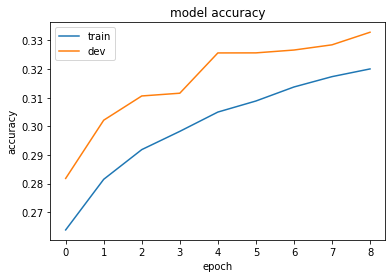

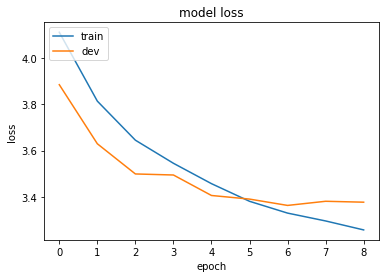

In [7]:
plt.plot(history['train_acc'])
plt.plot(history['dev_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history['train_loss'])
plt.plot(history['dev_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

BLEU Score on Test Set: 0.51, 0.31, 0.21, 0.1


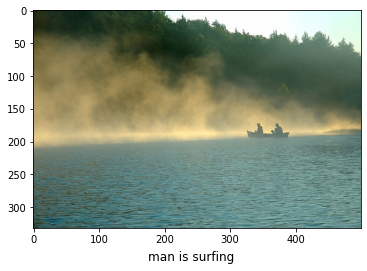

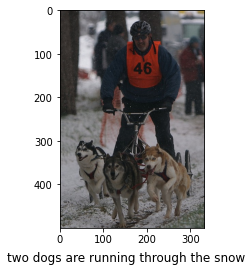

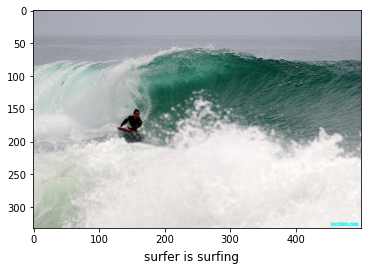

In [8]:
def sample_caption(model, max_length, feature):
    """
    Input: model, photo feature: shape=[1,4096]
    Return: A generated caption of that photo feature. Remove the startseq and endseq token.
    """
    
    caption = "startseq"
    while 1:
        #Prepare input to model
        encoded = [word2idx(word) for word in caption.split()]
        padded = keras.preprocessing.sequence.pad_sequences([encoded], maxlen=max_length, padding='pre')[0]
        padded = padded.reshape((1, max_length))
        
        pred_Y = model.predict([feature, padded])[0,-1,:]
        next_word = idx2word(pred_Y.argmax())
        
        #Update caption
        caption = caption + ' ' + next_word
        
        #Terminate condition: caption length reaches maximum / reach endseq
        if next_word == 'endseq' or len(caption.split()) >= max_length:
            break
    
    #Remove the (startseq, endseq)
    caption = caption.replace('startseq ', '')
    caption = caption.replace(' endseq', '')
    
    return(caption)

def evaluate_model(model, test_caption_dict, test_features, max_length):
    """
    Print: The evaluation score based on BLEU. 
    Also, sample 3 captions using the test images.
    """
    hypo_captions_list = []
    ref_captions_list = []
    disp_captions_dict = {}
    for photo_id, caption_list in test_caption_dict.items():
        #Reference texts
        ref_captions = []
        for c in caption_list:
            ref_captions.append(c.split())
        ref_captions_list.append(ref_captions)
        
        #Sampled texts
        feature = test_features[photo_id]
        samp_caption = sample_caption(model, max_length, feature)
        hypo_captions_list.append(samp_caption.split())
        
        #save the sampled caption for each test photo
        disp_captions_dict[photo_id] = samp_caption
    
    #Evaluate the model
    bleu1 = np.round(corpus_bleu(ref_captions_list, hypo_captions_list, weights=(1, 0, 0, 0)), 2)
    bleu2 = np.round(corpus_bleu(ref_captions_list, hypo_captions_list, weights=(0.5, 0.5, 0, 0)), 2)
    bleu3 = np.round(corpus_bleu(ref_captions_list, hypo_captions_list, weights=(0.3, 0.3, 0.3, 0)), 2)
    bleu4 = np.round(corpus_bleu(ref_captions_list, hypo_captions_list, weights=(0.25, 0.25, 0.25, 0.25)), 2)
    
    print("BLEU Score on Test Set: {b1}, {b2}, {b3}, {b4}".format(b1=bleu1, b2=bleu2, b3=bleu3, b4=bleu4))
    
    #Visualize the images and captions
    photo_ids = list(test_caption_dict.keys())
    np.random.seed(1)
    samples = np.random.choice(np.arange(len(photo_ids)), 3, replace=False)
    
    for i in range(len(samples)):
        photo_id = photo_ids[samples[i]]
        
        fn = "/content/drive/My Drive/Flickr8k_Dataset/" + photo_id + '.jpg'
        img = keras.preprocessing.image.load_img(fn)
        plt.figure(i+1)
        plt.imshow(img)
        plt.figtext(0.5, 0.01, disp_captions_dict[photo_id], wrap=True, horizontalalignment='center', fontsize=12)
        

evaluate_model(model, test_caption_dict, test_features, max_length)